In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [90]:
df = pd.read_csv('sample_data/PJME_hourly.csv')
df.head(3)

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0


In [91]:
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [92]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [93]:
df.tail()

,PJME_MW
Datetime,
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0
2018-01-01 23:00:00,40164.0
2018-01-02 00:00:00,38608.0


In [94]:
df = df.query('PJME_MW > 19_000').copy()

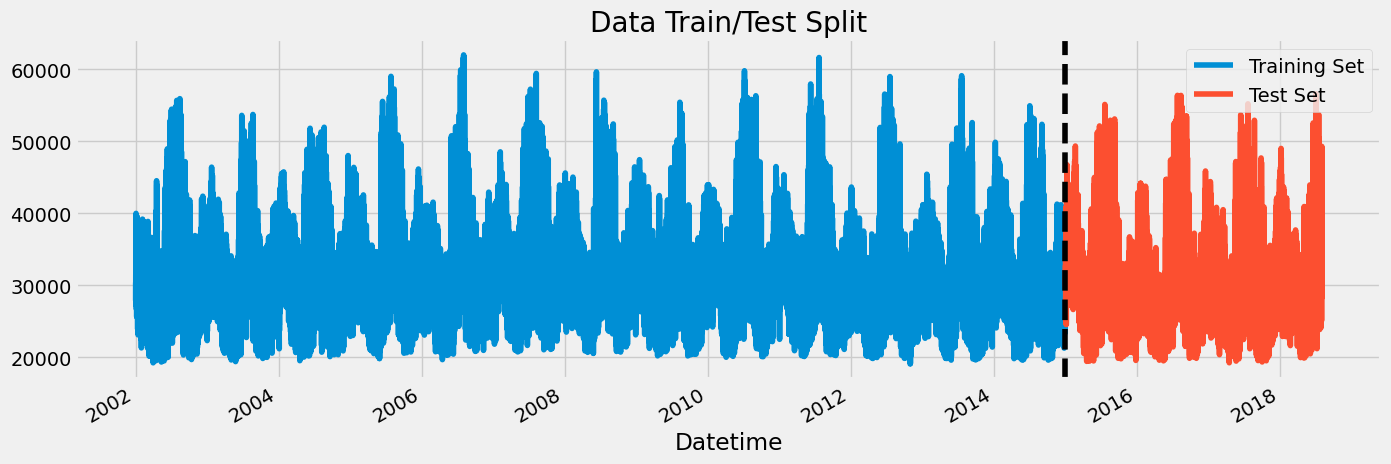

In [95]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [96]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

In [97]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [98]:
df.sample(5)

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2017-10-30 09:00:00,29376.0,9,0,4,10,2017,303,30,44
2005-04-18 01:00:00,22246.0,1,0,2,4,2005,108,18,16
2018-04-27 00:00:00,23786.0,0,4,2,4,2018,117,27,17
2006-01-26 03:00:00,29578.0,3,3,1,1,2006,26,26,4
2014-02-05 15:00:00,35968.0,15,2,1,2,2014,36,5,6


In [99]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [100]:
df = add_lags(df)

In [101]:
df.tail()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,,
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,42256.0,41485.0,38804.0
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,41210.0,40249.0,38748.0
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,39525.0,38698.0,37330.0
2018-08-02 23:00:00,38500.0,23,3,3,8,2018,214,2,31,36490.0,35406.0,34552.0
2018-08-03 00:00:00,35486.0,0,4,3,8,2018,215,3,31,33539.0,32094.0,31695.0


# Create our Model

In [102]:
fold = 0
preds = []
scores = []

for train_idx, val_idx in tss.split(df):

    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year','lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_val = test[FEATURES]
    y_val = test[TARGET]

#     model = Sequential()
# model.add(LSTM(units=64, activation='relu', input_shape=(24, FEATURES)))
# model.add(Dense(units=1)) # Single output for regression

# model.compile(loss='mean_squared_error', optimizer='adam')

# # Train the model
# model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping])

# # Evaluate on test set
# y_pred = model.predict(X_val)
# rmse = np.sqrt(mean_squared_error(y_val, y_pred))
# print(f"RMSE on test set: {rmse:.2f}")

# # Forecast future energy consumption
# future_predictions = model.predict(FEATURES) # future_X contains features for future timestamps


In [103]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Assuming you have already preprocessed your dataset
time_steps = 24 # Number of time steps (look-back window)
num_features = len(FEATURES) # Number of features

# Define the model
model = Sequential()
model.add(LSTM(units=64, activation='relu', input_shape=(time_steps, num_features)))
model.add(Dense(units=1)) # Single output for regression

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Fit the model


# Calculate the total number of features per sample
num_features = X_train.shape[1]

# Calculate the correct number of time steps
time_steps = X_train.size // (X_train.shape[0] * num_features)

# Now reshape with the correct dimensions
X_train_reshaped = X_train.values.reshape((X_train.shape[0], time_steps, num_features))

# Assuming X_train and X_val are pandas DataFrames or numpy arrays
# Reshape the data to be 3-dimensional: [samples, time steps, features]
# X_train_reshaped = X_train.values.reshape((X_train.shape[0], time_steps, num_features))
X_val_reshaped = X_val.values.reshape((X_val.shape[0], time_steps, num_features))

# Now, use the reshaped data for training and validation
model.fit(X_train_reshaped, y_train, epochs=50, validation_data=(X_val_reshaped, y_val), callbacks=[early_stopping])

# model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Evaluate on test set
y_pred = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"RMSE on validation set: {rmse:.2f}")

# Forecast future energy consumption
future_predictions = model.predict(future_X) # future_X contains features for future timestamps

Epoch 1/50


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_10" is incompatible with the layer: expected shape=(None, 24, 9), found shape=(None, 1, 9)
